In [1]:
import pandas as pd
import pylogit
import biogeme
from statsmodels.formula.api import logit
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
sacog = pd.read_excel('sacog_recoded_for_qianhua.xlsx')

In [3]:
# Solve inconsistency in data coding and save as new dataset
sacog = sacog.replace('Never ', 'Never')
sacog.to_excel('sacog_recoded_012021.xlsx')

In [4]:
never = ["Never", "Almost never"]
never_and_noRes = ["Never", "Almost never", 'No Response']

def count_(cat):
    past_year_freq = 'PastYear-ECommerce-Frequency-' + cat
    may_freq = 'May-ECommerce-Frequency-' + cat
    may_order = 'May-ECommerce-Orders-' + cat
    oldUser = sacog[~sacog[past_year_freq].isin(never_and_noRes)]
    pastNever = sacog[sacog[past_year_freq].isin(never)]
    adopter = pastNever[(pastNever[may_order] > 0) | (~pastNever[may_freq].isin(never_and_noRes))]
    NonAdopter = pastNever[(pastNever[may_order] == 0) & pastNever[may_freq].isin(never)]
    quiter = oldUser[(oldUser[may_order] == 0) & (oldUser[may_freq].isin(never))]
    keeper = oldUser[(oldUser[may_order] > 0) | (~oldUser[may_freq].isin(never_and_noRes))]
    nowUser = sacog[(sacog[may_order] > 0) | (~sacog[may_freq].isin(never_and_noRes))]
    return [len(oldUser),
           len(pastNever), 
           len(adopter),
           len(NonAdopter),
           len(quiter),
           len(keeper),
           len(nowUser),
           oldUser,
           pastNever,
           adopter,
           NonAdopter,
           quiter,
           keeper,
           nowUser
           ]

dict_ = {}
cat_ = ['PreparedFood', 'Groceries', 'OtherFood', 'PaperCleaning', 'Clothing', 'HomeOffice', 'Medication', 'ChildcareItems', 'Other']
for cat in cat_:
    dict_[cat] = count_(cat)

In [5]:
def adoption(row, cat):
    may_freq = 'May-ECommerce-Frequency-' + cat
    may_order = 'May-ECommerce-Orders-' + cat
    if (row[may_order] > 0) | (row[may_freq] not in never_and_noRes):
        return 1 # Adopt/keeper
    elif (row[may_order] == 0) & (row[may_freq] in never):
        return 0 # Not Adopt/quiter
    else:
        return 999 # can't identify 

In [6]:
def oldNew(row, cat):
    may_freq = 'May-ECommerce-Frequency-' + cat
    may_order = 'May-ECommerce-Orders-' + cat
    past_year_freq = 'PastYear-ECommerce-Frequency-' + cat
    if (row[may_order] > 0) | (row[may_freq] not in never_and_noRes):
        if row[past_year_freq] not in never_and_noRes:
            return 1 #old user
        elif row[past_year_freq] in never:
            return 0 #new user
        else:
            return 999
    else:
        return 999

In [7]:
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
from scipy.stats import t

def independent_ttest_2(data1, data2, alpha):
    # calculate means
    mean1, mean2 = mean(data1), mean(data2)
    # Sample size
    n1, n2 = len(data1), len(data2)
    df = n1 + n2 - 2
    # calculate standard errors
    se_p_2 = (sum((data1 - mean1)**2.0) + sum((data2 - mean2)**2.0))/df
    # standard error on the difference between the samples
    sed = sqrt(se_p_2)
    # calculate the t statistic
    t_stat = (mean1 - mean2) / (sed*sqrt(1/n1 + 1/n2))
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

## Try to explore inertia by looking into subscription, too much record without response. 
Expect quiter of Egrocery has shorter time of subscription experience of Amazon Prime, contrary was found.

In [7]:
list(sacog.columns)

['Unnamed: 0',
 'Duration (in seconds)',
 'Response ID',
 'May-WorkingHours',
 'May-TelecommutingDays',
 'May-Trips-Commuting',
 'May-Trips-Medical',
 'May-Trips-Gym',
 'May-Trips-ToSchool',
 'May-Trips-FromSchool',
 'May-Trips-Bar',
 'May-Trips-MovieTheater',
 'May-Trips-Friends',
 'May-Trips-Family',
 'May-Trips-Other',
 'May-Trips-OtherType',
 'CommutingFollowup',
 'May-TripDistance-Commuting',
 'May-TripDistance-Medical',
 'May-TripDistance-Gym',
 'May-TripDistance-ToSchool',
 'May-TripDistance-FromSchool',
 'May-TripDistance-Bar',
 'May-TripDistance-MovieTheater',
 'May-TripDistance-Friends',
 'May-TripDistance-Family',
 'May-TripDistance-Other',
 'May-TripDistance-OtherType',
 'May-TripMode-Commuting',
 'May-TripMode-Medical',
 'May-TripMode-Gym',
 'May-TripMode-ToSchool',
 'May-TripMode-FromSchool',
 'May-TripMode-Bar',
 'May-TripMode-MovieTheater',
 'May-TripMode-Friends',
 'May-TripMode-Family',
 'May-TripMode-Other',
 'May-TripMode-OtherType',
 'LivingInSamePlace',
 'JanFeb-W

In [8]:
sacog['Rewards-Length-AmazonPrime'].value_counts()

Longer than 5 years            126
Between 2 and 5 years           91
No Response                     76
Between 1 and 2 years           19
Between 3 months and 1 year     10
Fewer than 3 months              5
Name: Rewards-Length-AmazonPrime, dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

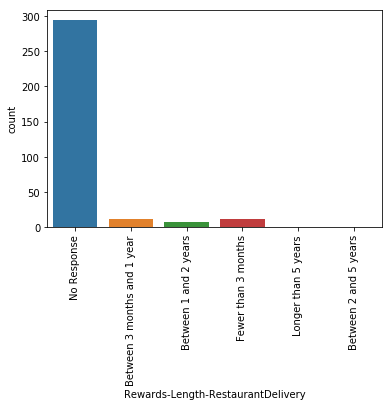

In [9]:
#sns.countplot(sacog['Rewards-Length-GroceryDelivery'])
#plt.xticks(rotation = 90)
#sns.countplot(sacog['Rewards-Length-AmazonPrime'])
#plt.xticks(rotation = 90)
sns.countplot(sacog['Rewards-Length-RestaurantDelivery'])
plt.xticks(rotation = 90)

In [28]:
keepG = oldUserG[oldUserG['keep'] == 1]
quitG = oldUserG[oldUserG['keep'] == 0]
keepF = oldUserF[oldUserF['keep'] == 1]
quitF = oldUserF[oldUserF['keep'] == 0]

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

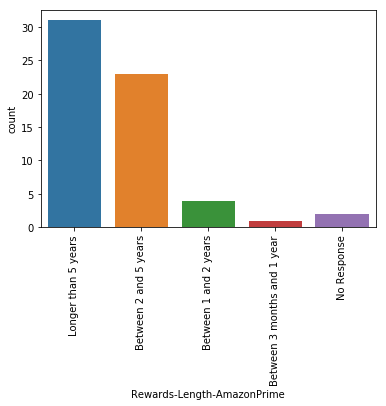

In [29]:
sns.countplot(keepG['Rewards-Length-AmazonPrime'])
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

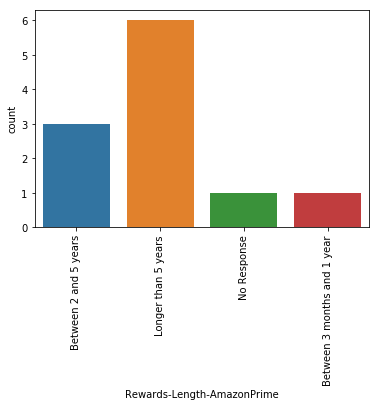

In [30]:
sns.countplot(quitG['Rewards-Length-AmazonPrime'])
plt.xticks(rotation = 90)

In [ ]:
 'Behavior-OnlyList',
 'Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut',
    
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool',
 'ECommerce-Food-OtherThought',
 'ECommerce-Food-OtherThoughtType',
    
 'Attitude-SatisfiedWithLife',
 'Attitude-ZoomFatigue',
 'Attitude-SociallyIsolated',
 'Attitude-Stressed',
 'Attitude-HaveEnoughTime',
 'Attitude-HaveEnoughFood',
 'Attitude-HaveEnoughMeds',
 'Attitude-WorryBasicNeeeds',

 'Trust-MedicalWorkers',
 'Trust-BusTrainDrivers',
 'Trust-Amazon',
 'Trust-Walmart',
 'Trust-Target',
 'Trust-TNC',
 'Trust-FoodDeliveryCompanies',
 'Trust-GroceryDeliveryCompanies',
 'Trust-TNCDrivers',
 'Trust-TaxiDrivers',
 'Trust-USPSWorkers',
 'Trust-ParcelDeliveryDrivers',
 'Trust-AmazonDeliveryDrivers',
 'Trust-FoodDeliveryDrivers',
 'Trust-GroceryDeliveryDrivers',

 'COVID-PPEReducesContraction',
 'COVID-PPEReducesTransmission',
 'COVID-AbleSocialDistance',
 'COVID-Trust-Community',

'NonFood-OnlineRelaxing',
 'NonFood-EnjoyOnlineClothing',
 'NonFood-EnjoyOnlineElectronice',
 'NonFood-SearchForBestDeals',
 'NonFood-EnjoyBrowsingWOBuying',
 'NonFood-InPersonClothingChore',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-NonFood-EnvironmentallyFriendly',
 'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',
 'ECommerce-NonFood-OtherThought',
 'ECommerce-NonFood-OtherThoughtType',

## 1) E-prepared-food

In [8]:
pastNeverF = count_('PreparedFood')[8]
oldUserF = count_('PreparedFood')[7]

In [9]:
pastNeverF['adopt'] = pastNeverF.apply(lambda row: adoption(row, 'PreparedFood'), axis = 1)
oldUserF['keep'] = oldUserF.apply(lambda row: adoption(row, 'PreparedFood'), axis = 1)
sacog['oldnew'] = sacog.apply(lambda row: oldNew(row, 'PreparedFood'), axis = 1)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
att_ls = ['Behavior-NotMindRestaurantOnline',
 'Behavior-PickupExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-FoodDeliveryCompanies',
 'Trust-FoodDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']

## Hypothesis
## 1. Adopter will 1) show greater confidence towards COVID protection method 

In [30]:
adoptF = pastNeverF[pastNeverF['adopt'] != 999][['adopt', 
 'Behavior-NotMindRestaurantOnline',
 'Behavior-PickupExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-FoodDeliveryCompanies',
 'Trust-FoodDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

keepF = oldUserF[oldUserF['keep'] != 999][['keep', 'Behavior-NotMindRestaurantOnline',
 'Behavior-PickupExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-FoodDeliveryCompanies',
 'Trust-FoodDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

oldnewF = sacog[sacog['oldnew'] != 999][['oldnew', 'Behavior-NotMindRestaurantOnline',
 'Behavior-PickupExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-FoodDeliveryCompanies',
 'Trust-FoodDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

In [12]:
adoptF = pastNeverF[pastNeverF['adopt'] != 999][['adopt', 'COVID-PPEReducesContraction', 'COVID-PPEReducesTransmission', 
                  'COVID-AbleSocialDistance', 'Trust-FoodDeliveryCompanies',
                  'Trust-FoodDeliveryDrivers', 'Behavior-PickupExcuseToGetOut',
                  'Behavior-NotMindRestaurantOnline', 'ECommerce-Food-HardToKnowExactly',
                  'ECommerce-Food-WorryAboutTheft', 'Attitude-SociallyIsolated',
                  'Attitude-Stressed', 'Attitude-HaveEnoughFood', 'Online-Ease']]
keepF = oldUserF[oldUserF['keep'] != 999][['keep', 'COVID-PPEReducesContraction', 'COVID-PPEReducesTransmission', 
                  'COVID-AbleSocialDistance', 'Trust-FoodDeliveryCompanies',
                  'Trust-FoodDeliveryDrivers', 'Behavior-PickupExcuseToGetOut',
                  'Behavior-NotMindRestaurantOnline', 'ECommerce-Food-HardToKnowExactly',
                  'ECommerce-Food-WorryAboutTheft', 'Attitude-SociallyIsolated',
                  'Attitude-Stressed', 'Attitude-HaveEnoughFood', 'Online-Ease']]
oldnewF = sacog[sacog['oldnew'] != 999][['oldnew', 'COVID-PPEReducesContraction', 'COVID-PPEReducesTransmission', 
                  'COVID-AbleSocialDistance', 'Trust-FoodDeliveryCompanies',
                  'Trust-FoodDeliveryDrivers', 'Behavior-PickupExcuseToGetOut',
                  'Behavior-NotMindRestaurantOnline', 'ECommerce-Food-HardToKnowExactly',
                  'ECommerce-Food-WorryAboutTheft', 'Attitude-SociallyIsolated',
                  'Attitude-Stressed', 'Attitude-HaveEnoughFood', 'Online-Ease']]

In [34]:
# Remove record with response -9998 or 997, reduce to 89 records
adoptF = adoptF[~np.isin(adoptF, [-9998, 997]).any(axis=1)]
keepF = keepF[~np.isin(keepF, [-9998, 997]).any(axis=1)]
oldnewF = oldnewF[~np.isin(oldnewF, [-9998, 997]).any(axis=1)]

In [14]:
adoptF.describe()
#keepF.describe()
#oldnewF.describe()

,adopt,COVID-PPEReducesContraction,COVID-PPEReducesTransmission,COVID-AbleSocialDistance,Trust-FoodDeliveryCompanies,Trust-FoodDeliveryDrivers,Behavior-PickupExcuseToGetOut,Behavior-NotMindRestaurantOnline,ECommerce-Food-HardToKnowExactly,ECommerce-Food-WorryAboutTheft,Attitude-SociallyIsolated,Attitude-Stressed,Attitude-HaveEnoughFood,Online-Ease
count,89.000000,89.000000,89.000000,89.00000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.550562,3.966292,4.359551,4.41573,3.258427,3.629213,2.269663,3.146067,3.932584,2.640449,2.865169,2.988764,4.550562,4.101124
std,0.500255,1.210273,1.014074,0.61808,0.885849,0.728978,1.105400,1.092854,0.876431,1.100074,1.109781,1.123048,0.522477,0.798364
min,0.000000,1.000000,1.000000,2.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000
25%,0.000000,3.000000,4.000000,4.00000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,4.000000,4.000000
50%,1.000000,4.000000,5.000000,4.00000,3.000000,4.000000,2.000000,3.000000,4.000000,2.000000,3.000000,3.000000,5.000000,4.000000
75%,1.000000,5.000000,5.000000,5.00000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,5.000000,5.000000
max,1.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [45]:
np.asarray(adoptF)

array([[1, 5, 3, ..., 5, 5, 5],
       [1, 2, 3, ..., 4, 3, 5],
       [0, 3, 3, ..., 5, 5, 5],
       ...,
       [0, 3, 1, ..., 5, 5, 4],
       [1, 4, 2, ..., 5, 4, 5],
       [1, 2, 3, ..., 2, 4, 4]])

In [36]:
import statsmodels.api as sm

X = adoptF.iloc[:,1:]
Y = adoptF.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary())


Optimization terminated successfully.
         Current function value: 0.483957
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  adopt   No. Observations:                   88
Model:                          Logit   Df Residuals:                       72
Method:                           MLE   Df Model:                           15
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                  0.2952
Time:                        15:28:09   Log-Likelihood:                -42.588
converged:                       True   LL-Null:                       -60.428
Covariance Type:            nonrobust   LLR p-value:                  0.001967
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -1.0217   

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [35]:
print(tabulate([[att, 
                     adoptF[adoptF.adopt == 1][att].mean(), 
                     adoptF[adoptF.adopt == 0][att].mean(),
                     independent_ttest_2(adoptF[adoptF.adopt == 1][att], adoptF[adoptF.adopt == 0][att], 0.05)[3]
                    ] for att in att_ls], headers=['Attitude', 'Adopt', 'Non-adopt', 'P-value']))

Attitude                                  Adopt    Non-adopt      P-value
--------------------------------------  -------  -----------  -----------
Behavior-NotMindRestaurantOnline        3.5102       2.71795  0.000520551
Behavior-PickupExcuseToGetOut           2.65306      1.79487  0.000205504
ECommerce-Food-EnvironmentallyFriendly  2.89796      2.76923  0.562192
ECommerce-Food-SupportLocal             3.79592      3.82051  0.894373
ECommerce-Food-SavesTime                3.4898       3.17949  0.107534
ECommerce-Food-SavesMoney               2.28571      2.23077  0.775557
ECommerce-Food-HardToKnowExactly        3.93878      3.92308  0.934423
ECommerce-Food-WorryAboutTheft          2.5102       2.76923  0.273505
ECommerce-Food-AvoidCarrying            2            2.28205  0.186793
ECommerce-Food-InstantIsCool            3.04082      2.53846  0.0144442
Trust-FoodDeliveryCompanies             3.26531      3.23077  0.857288
Trust-FoodDeliveryDrivers               3.73469      3.48718  0.

In [37]:
X = keepF.iloc[:,1:]
Y = keepF.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary()) 

Optimization terminated successfully.
         Current function value: 0.224527
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   keep   No. Observations:                  138
Model:                          Logit   Df Residuals:                      122
Method:                           MLE   Df Model:                           15
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                  0.3469
Time:                        15:33:48   Log-Likelihood:                -30.985
converged:                       True   LL-Null:                       -47.442
Covariance Type:            nonrobust   LLR p-value:                  0.004824
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     14.9250   

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [55]:
len(keepF[keepF.keep == 1])


123

In [38]:
print(tabulate([[att, 
                     keepF[keepF.keep == 1][att].mean(), 
                     keepF[keepF.keep == 0][att].mean(),
                     independent_ttest_2(keepF[keepF.keep == 1][att], keepF[keepF.keep == 0][att], 0.05)[3]
                    ] for att in att_ls], headers=['Attitude', 'Keep', 'Quit', 'P-value']))

Attitude                                   Keep     Quit    P-value
--------------------------------------  -------  -------  ---------
Behavior-NotMindRestaurantOnline        4        3.46667  0.0301514
Behavior-PickupExcuseToGetOut           2.76423  3.06667  0.367102
ECommerce-Food-EnvironmentallyFriendly  2.97561  3.2      0.374515
ECommerce-Food-SupportLocal             3.76423  4.13333  0.139094
ECommerce-Food-SavesTime                4.00813  4.13333  0.55336
ECommerce-Food-SavesMoney               2.29268  2.33333  0.86826
ECommerce-Food-HardToKnowExactly        3.78862  4.13333  0.156131
ECommerce-Food-WorryAboutTheft          2.70732  2.26667  0.140222
ECommerce-Food-AvoidCarrying            2.52033  2.06667  0.168917
ECommerce-Food-InstantIsCool            3.43089  3.46667  0.906462
Trust-FoodDeliveryCompanies             3.26016  3.66667  0.0991758
Trust-FoodDeliveryDrivers               3.69919  3.73333  0.856736
COVID-PPEReducesContraction             4.06504  4.26667  0.

In [48]:
X = oldnewF.iloc[:,1:]
Y = oldnewF.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary()) 

Optimization terminated successfully.
         Current function value: 0.490401
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 oldnew   No. Observations:                  172
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                           15
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                  0.1793
Time:                        21:47:35   Log-Likelihood:                -84.349
converged:                       True   LL-Null:                       -102.77
Covariance Type:            nonrobust   LLR p-value:                  0.001333
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.2180   

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [41]:
print(tabulate([[att, 
                     oldnewF[oldnewF.oldnew == 1][att].mean(), 
                     oldnewF[oldnewF.oldnew == 0][att].mean(),
                     independent_ttest_2(oldnewF[oldnewF.oldnew == 1][att], oldnewF[oldnewF.oldnew == 0][att], 0.05)[3]
                    ] for att in att_ls], headers=['Attitude', 'Old user', 'New user', 'P-value']))

Attitude                                    old      new      P-value
--------------------------------------  -------  -------  -----------
Behavior-NotMindRestaurantOnline        4        3.5102   0.00194458
Behavior-PickupExcuseToGetOut           2.76423  2.65306  0.578249
ECommerce-Food-EnvironmentallyFriendly  2.97561  2.89796  0.62222
ECommerce-Food-SupportLocal             3.76423  3.79592  0.8388
ECommerce-Food-SavesTime                4.00813  3.4898   0.000119993
ECommerce-Food-SavesMoney               2.29268  2.28571  0.960479
ECommerce-Food-HardToKnowExactly        3.78862  3.93878  0.316943
ECommerce-Food-WorryAboutTheft          2.70732  2.5102   0.268389
ECommerce-Food-AvoidCarrying            2.52033  2        0.00605083
ECommerce-Food-InstantIsCool            3.43089  3.04082  0.0278103
Trust-FoodDeliveryCompanies             3.26016  3.26531  0.973577
Trust-FoodDeliveryDrivers               3.69919  3.73469  0.76451
COVID-PPEReducesContraction             4.06504  4.1

In [49]:
print(tabulate([[att, 
                     oldnewF[oldnewF.oldnew == 1][att].mean(), 
                     oldnewF[oldnewF.oldnew == 0][att].mean(), 
                     adoptF[adoptF.adopt == 0][att].mean(),
                     independent_ttest_2(oldnewF[oldnewF.oldnew == 1][att], oldnewF[oldnewF.oldnew == 0][att], 0.05)[3],
                     independent_ttest_2(oldnewF[oldnewF.oldnew == 0][att], adoptF[adoptF.adopt == 0][att], 0.05)[3]
                    ] for att in att_ls], headers=['Attitude', 'Old user', 'New user', 'Non-adopter', 'P-value1', 'P-value2' ]))

Attitude                                  Old user    New user    Non-adopter     P-value1     P-value2
--------------------------------------  ----------  ----------  -------------  -----------  -----------
Behavior-NotMindRestaurantOnline           4           3.5102         2.71795  0.00194458   0.000520551
Behavior-PickupExcuseToGetOut              2.76423     2.65306        1.79487  0.578249     0.000205504
ECommerce-Food-EnvironmentallyFriendly     2.97561     2.89796        2.76923  0.62222      0.562192
ECommerce-Food-SupportLocal                3.76423     3.79592        3.82051  0.8388       0.894373
ECommerce-Food-SavesTime                   4.00813     3.4898         3.17949  0.000119993  0.107534
ECommerce-Food-SavesMoney                  2.29268     2.28571        2.23077  0.960479     0.775557
ECommerce-Food-HardToKnowExactly           3.78862     3.93878        3.92308  0.316943     0.934423
ECommerce-Food-WorryAboutTheft             2.70732     2.5102         2.76923  

In [53]:
len(oldnewF[oldnewF.oldnew == 0])

49

## adopt: excuse to pickup, not mind res online
## not adopt: worry about theft, online ease


In [39]:
import statsmodels.api as sm

X = adoptF.iloc[:,1:]
Y = adoptF.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary())


Optimization terminated successfully.
         Current function value: 0.489977
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:                  adopt   No. Observations:                   92
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                           13
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                  0.2909
Time:                        21:24:41   Log-Likelihood:                -45.078
converged:                       True   LL-Null:                       -63.574
Covariance Type:            nonrobust   LLR p-value:                 0.0004156
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.7578      3.471     -0.5

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/apple/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1807: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/apple/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1807: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


quit: trust towards food delivery company, online ease
keep: worry about theft, not mind restaurant online

In [40]:
X = keepF.iloc[:,1:]
Y = keepF.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary()) 

Optimization terminated successfully.
         Current function value: 0.250810
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                   keep   No. Observations:                  140
Model:                          Logit   Df Residuals:                      126
Method:                           MLE   Df Model:                           13
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                  0.2634
Time:                        21:24:46   Log-Likelihood:                -35.113
converged:                       True   LL-Null:                       -47.670
Covariance Type:            nonrobust   LLR p-value:                   0.02231
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                7.4661      4.720      1.5

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


old:
new:

In [41]:
X = oldnewF.iloc[:,1:]
Y = oldnewF.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary()) 

Optimization terminated successfully.
         Current function value: 0.519093
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                 oldnew   No. Observations:                  174
Model:                          Logit   Df Residuals:                      160
Method:                           MLE   Df Model:                           13
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                  0.1268
Time:                        21:24:50   Log-Likelihood:                -90.322
converged:                       True   LL-Null:                       -103.44
Covariance Type:            nonrobust   LLR p-value:                   0.01583
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.7580      2.427     -0.7

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2) E-grocery

In [104]:
pastNeverG = count_('Groceries')[8]
oldUserG = count_('Groceries')[7]

In [105]:
pastNeverG['adopt'] = pastNeverG.apply(lambda row: adoption(row, 'Groceries'), axis = 1)
oldUserG['keep'] = oldUserG.apply(lambda row: adoption(row, 'Groceries'), axis = 1)
sacog['oldnewG'] = sacog.apply(lambda row: oldNew(row, 'Groceries'), axis = 1)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [106]:
adoptG = pastNeverG[pastNeverG['adopt'] != 999][['adopt', 
 'Behavior-OnlyList',
 'Behavior-NotMindGroceriesOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-GroceryDeliveryCompanies',
 'Trust-GroceryDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

keepG = oldUserG[oldUserG['keep'] != 999][['keep', 'Behavior-OnlyList',
 'Behavior-NotMindGroceriesOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-GroceryDeliveryCompanies',
 'Trust-GroceryDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

oldnewG = sacog[sacog['oldnewG'] != 999][['oldnewG', 'Behavior-OnlyList',
 'Behavior-NotMindGroceriesOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-GroceryDeliveryCompanies',
 'Trust-GroceryDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

In [107]:
att_lsG = ['Behavior-OnlyList',
 'Behavior-NotMindGroceriesOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut', 
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool', 
 'Trust-GroceryDeliveryCompanies',
 'Trust-GroceryDeliveryDrivers',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']

In [84]:
#adoptG = pastNeverG[pastNeverG['adopt'] != 999][['adopt', 'COVID-PPEReducesContraction', 'COVID-PPEReducesTransmission', 
                  'COVID-AbleSocialDistance', 'Trust-GroceryDeliveryCompanies',
                  'Trust-GroceryDeliveryDrivers', 'Behavior-GroceryExcuseToGetOut',
                  'Behavior-NotMindGroceriesOnline', 'Behavior-InPersonIsChore', 
                  'ECommerce-Food-HardToKnowExactly', 'ECommerce-Food-WorryAboutTheft', 
                  'Attitude-SociallyIsolated', 'Attitude-Stressed', 
                  'Attitude-HaveEnoughFood', 'Online-Ease']]
#keepG = oldUserG[oldUserG['keep'] != 999][['keep', 'COVID-PPEReducesContraction', 'COVID-PPEReducesTransmission', 
                  'COVID-AbleSocialDistance', 'Trust-GroceryDeliveryCompanies',
                  'Trust-GroceryDeliveryDrivers', 'Behavior-GroceryExcuseToGetOut',
                  'Behavior-NotMindGroceriesOnline', 'Behavior-InPersonIsChore', 
                  'ECommerce-Food-HardToKnowExactly', 'ECommerce-Food-WorryAboutTheft', 
                  'Attitude-SociallyIsolated', 'Attitude-Stressed', 
                  'Attitude-HaveEnoughFood', 'Online-Ease']]
#oldnewG = sacog[sacog['oldnewG'] != 999][['oldnewG', 'COVID-PPEReducesContraction', 'COVID-PPEReducesTransmission', 
                  'COVID-AbleSocialDistance', 'Trust-FoodDeliveryCompanies',
                  'Trust-FoodDeliveryDrivers', 'Behavior-PickupExcuseToGetOut',
                  'Behavior-NotMindRestaurantOnline', 'ECommerce-Food-HardToKnowExactly',
                  'ECommerce-Food-WorryAboutTheft', 'Attitude-SociallyIsolated',
                  'Attitude-Stressed', 'Attitude-HaveEnoughFood', 'Online-Ease']]

In [108]:
# Remove record with response -9998 or 997, reduce to 87 records
adoptG = adoptG[~np.isin(adoptG, [-9998, 997]).any(axis=1)]
keepG = keepG[~np.isin(keepG, [-9998, 997]).any(axis=1)]
oldnewG = oldnewG[~np.isin(oldnewG, [-9998, 997]).any(axis=1)]

In [109]:
X = adoptG.iloc[:,1:]
Y = adoptG.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.456963
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  adopt   No. Observations:                  150
Model:                          Logit   Df Residuals:                      132
Method:                           MLE   Df Model:                           17
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                  0.2871
Time:                        17:21:06   Log-Likelihood:                -68.545
converged:                       True   LL-Null:                       -96.155
Covariance Type:            nonrobust   LLR p-value:                 6.313e-06
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -5.5435   

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [110]:
print(tabulate([[att, 
                     adoptG[adoptG.adopt == 1][att].mean(), 
                     adoptG[adoptG.adopt == 0][att].mean(),
                     independent_ttest_2(adoptG[adoptG.adopt == 1][att], adoptG[adoptG.adopt == 0][att], 0.05)[3]
                    ] for att in att_lsG], headers=['Attitude', 'Adopt', 'Non-adopt', 'P-value']))

Attitude                                  Adopt    Non-adopt      P-value
--------------------------------------  -------  -----------  -----------
Behavior-OnlyList                       3            3.30303  0.141059
Behavior-NotMindGroceriesOnline         3.41176      2.42424  3.09414e-06
Behavior-InPersonIsChore                2.92157      2.60606  0.116857
Behavior-GroceryExcuseToGetOut          3.39216      3.16162  0.265087
ECommerce-Food-EnvironmentallyFriendly  2.92157      2.79798  0.458353
ECommerce-Food-SupportLocal             3.7451       3.76768  0.885168
ECommerce-Food-SavesTime                3.70588      3.50505  0.211037
ECommerce-Food-SavesMoney               2.43137      2.25253  0.275836
ECommerce-Food-HardToKnowExactly        4.15686      3.84848  0.0340163
ECommerce-Food-WorryAboutTheft          2.33333      2.86869  0.00509872
ECommerce-Food-AvoidCarrying            2.11765      2.28283  0.37736
ECommerce-Food-InstantIsCool            3.29412      2.94949  0.06

In [111]:
X = keepG.iloc[:,1:]
Y = keepG.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.196667
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   keep   No. Observations:                   70
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                           17
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                  0.5205
Time:                        17:22:16   Log-Likelihood:                -13.767
converged:                       True   LL-Null:                       -28.708
Covariance Type:            nonrobust   LLR p-value:                   0.02720
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -3.8733   

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [112]:
print(tabulate([[att, 
                     keepG[keepG.keep == 1][att].mean(), 
                     keepG[keepG.keep == 0][att].mean(),
                     independent_ttest_2(keepG[keepG.keep == 1][att], keepG[keepG.keep == 0][att], 0.05)[3]
                    ] for att in att_lsG], headers=['Attitude', 'Keep', 'Quit', 'P-value']))

Attitude                                   Keep    Quit    P-value
--------------------------------------  -------  ------  ---------
Behavior-OnlyList                       3.4         2.7  0.0703643
Behavior-NotMindGroceriesOnline         3.88333     3.4  0.266732
Behavior-InPersonIsChore                3.36667     3.1  0.515164
Behavior-GroceryExcuseToGetOut          3.05        3.3  0.568532
ECommerce-Food-EnvironmentallyFriendly  3.18333     3.1  0.792243
ECommerce-Food-SupportLocal             3.83333     4.2  0.232235
ECommerce-Food-SavesTime                4.11667     4.3  0.452303
ECommerce-Food-SavesMoney               2.16667     2.3  0.638158
ECommerce-Food-HardToKnowExactly        3.9         3.3  0.055985
ECommerce-Food-WorryAboutTheft          2.5         2.5  1
ECommerce-Food-AvoidCarrying            2.5         2.7  0.651257
ECommerce-Food-InstantIsCool            3.48333     3.5  0.966927
Trust-GroceryDeliveryCompanies          3.51667     3.1  0.142151
Trust-GroceryD

In [113]:
X = oldnewG.iloc[:,1:]
Y = oldnewG.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.539868
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                oldnewG   No. Observations:                  111
Model:                          Logit   Df Residuals:                       93
Method:                           MLE   Df Model:                           17
Date:                Fri, 19 Mar 2021   Pseudo R-squ.:                  0.2174
Time:                        17:22:55   Log-Likelihood:                -59.925
converged:                       True   LL-Null:                       -76.574
Covariance Type:            nonrobust   LLR p-value:                   0.01033
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -4.4796   

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [114]:
print(tabulate([[att, 
                     oldnewG[oldnewG.oldnewG == 1][att].mean(), 
                     oldnewG[oldnewG.oldnewG == 0][att].mean(),
                     independent_ttest_2(oldnewG[oldnewG.oldnewG == 1][att], oldnewG[oldnewG.oldnewG == 0][att], 0.05)[3]
                    ] for att in att_lsG], headers=['Attitude', 'Old User', 'New User', 'P-value']))

Attitude                                  Old User    New User    P-value
--------------------------------------  ----------  ----------  ---------
Behavior-OnlyList                          3.4         3        0.0688662
Behavior-NotMindGroceriesOnline            3.88333     3.41176  0.0569792
Behavior-InPersonIsChore                   3.36667     2.92157  0.0683238
Behavior-GroceryExcuseToGetOut             3.05        3.39216  0.156739
ECommerce-Food-EnvironmentallyFriendly     3.18333     2.92157  0.143162
ECommerce-Food-SupportLocal                3.83333     3.7451   0.622582
ECommerce-Food-SavesTime                   4.11667     3.70588  0.0137055
ECommerce-Food-SavesMoney                  2.16667     2.43137  0.1593
ECommerce-Food-HardToKnowExactly           3.9         4.15686  0.104891
ECommerce-Food-WorryAboutTheft             2.5         2.33333  0.421725
ECommerce-Food-AvoidCarrying               2.5         2.11765  0.104896
ECommerce-Food-InstantIsCool               3.48

In [115]:
print(tabulate([[att, 
                     oldnewG[oldnewG.oldnewG == 1][att].mean(), 
                     oldnewG[oldnewG.oldnewG == 0][att].mean(),
                     adoptG[adoptG.adopt == 0][att].mean(),
                     independent_ttest_2(oldnewG[oldnewG.oldnewG == 1][att], oldnewG[oldnewG.oldnewG == 0][att], 0.05)[3],
                     independent_ttest_2(oldnewG[oldnewG.oldnewG == 0][att], adoptG[adoptG.adopt == 0][att], 0.05)[3]
                    ] for att in att_lsG], headers=['Attitude', 'Old User', 'New User', 'Non-adopter', 'P-value1', 'P-value2']))

Attitude                                  Old User    New User    Non-adopter    P-value1     P-value2
--------------------------------------  ----------  ----------  -------------  ----------  -----------
Behavior-OnlyList                          3.4         3              3.30303   0.0688662  0.141059
Behavior-NotMindGroceriesOnline            3.88333     3.41176        2.42424   0.0569792  3.09414e-06
Behavior-InPersonIsChore                   3.36667     2.92157        2.60606   0.0683238  0.116857
Behavior-GroceryExcuseToGetOut             3.05        3.39216        3.16162   0.156739   0.265087
ECommerce-Food-EnvironmentallyFriendly     3.18333     2.92157        2.79798   0.143162   0.458353
ECommerce-Food-SupportLocal                3.83333     3.7451         3.76768   0.622582   0.885168
ECommerce-Food-SavesTime                   4.11667     3.70588        3.50505   0.0137055  0.211037
ECommerce-Food-SavesMoney                  2.16667     2.43137        2.25253   0.1593     

In [116]:
len(oldnewG[oldnewG.oldnewG == 1]),\
len(oldnewG[oldnewG.oldnewG == 0]),\
len(adoptG[adoptG.adopt == 1]),\
len(adoptG[adoptG.adopt == 0]),\
len(keepG[keepG.keep == 1]),\
len(keepG[keepG.keep == 0]),\

(60, 51, 51, 99, 60, 10)

## Next step: look into Eclothing attitudinal data

In [11]:
pastNeverC = count_('Clothing')[8]
oldUserC = count_('Clothing')[7]

In [12]:
pastNeverC['adopt'] = pastNeverC.apply(lambda row: adoption(row, 'Clothing'), axis = 1)
oldUserC['keep'] = oldUserC.apply(lambda row: adoption(row, 'Clothing'), axis = 1)
sacog['oldnewC'] = sacog.apply(lambda row: oldNew(row, 'Clothing'), axis = 1)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
adoptC = pastNeverC[pastNeverC['adopt'] != 999][['adopt', 
 'NonFood-OnlineRelaxing',
 'NonFood-EnjoyOnlineClothing',
 'NonFood-EnjoyOnlineElectronice',
 'NonFood-SearchForBestDeals',
 'NonFood-EnjoyBrowsingWOBuying',
 'NonFood-InPersonClothingChore',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-NonFood-EnvironmentallyFriendly',
 'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',
 'Trust-USPSWorkers',
 'Trust-ParcelDeliveryDrivers',
 'COVID-PPEReducesTransmission',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

keepC = oldUserC[oldUserC['keep'] != 999][['keep', 
 'NonFood-OnlineRelaxing',
 'NonFood-EnjoyOnlineClothing',
 'NonFood-EnjoyOnlineElectronice',
 'NonFood-SearchForBestDeals',
 'NonFood-EnjoyBrowsingWOBuying',
 'NonFood-InPersonClothingChore',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-NonFood-EnvironmentallyFriendly',
 'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',
 'Trust-USPSWorkers',
 'Trust-ParcelDeliveryDrivers',
 'COVID-PPEReducesTransmission',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

oldnewC = sacog[sacog['oldnewC'] != 999][['oldnewC', 
 'NonFood-OnlineRelaxing',
 'NonFood-EnjoyOnlineClothing',
 'NonFood-EnjoyOnlineElectronice',
 'NonFood-SearchForBestDeals',
 'NonFood-EnjoyBrowsingWOBuying',
 'NonFood-InPersonClothingChore',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-NonFood-EnvironmentallyFriendly',
 'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',
 'Trust-USPSWorkers',
 'Trust-ParcelDeliveryDrivers',
 'COVID-PPEReducesTransmission',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']]

In [15]:
att_lsC = ['NonFood-OnlineRelaxing',
 'NonFood-EnjoyOnlineClothing',
 'NonFood-EnjoyOnlineElectronice',
 'NonFood-SearchForBestDeals',
 'NonFood-EnjoyBrowsingWOBuying',
 'NonFood-InPersonClothingChore',
 'NonFood-RetailExcuseToGetOut',
 'ECommerce-NonFood-EnvironmentallyFriendly',
 'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool',
 'Trust-USPSWorkers',
 'Trust-ParcelDeliveryDrivers',
 'COVID-PPEReducesTransmission',
 'COVID-PPEReducesContraction',
 'COVID-AbleSocialDistance',
 'Online-Ease']

In [18]:
len(adoptC)

41

In [16]:
adoptC = adoptC[~np.isin(adoptC, [-9998, 997]).any(axis=1)]
keepC = keepC[~np.isin(keepC, [-9998, 997]).any(axis=1)]
oldnewC = oldnewC[~np.isin(oldnewC, [-9998, 997]).any(axis=1)]

In [17]:
import statsmodels.api as sm

X = adoptC.iloc[:,1:]
Y = adoptC.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.351033
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  adopt   No. Observations:                   41
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                           22
Date:                Mon, 22 Mar 2021   Pseudo R-squ.:                  0.4655
Time:                        17:13:54   Log-Likelihood:                -14.392
converged:                       True   LL-Null:                       -26.925
Covariance Type:            nonrobust   LLR p-value:                    0.2939
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                       -1

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [20]:
print(tabulate([[att, 
                     adoptC[adoptC.adopt == 1][att].mean(), 
                     adoptC[adoptC.adopt == 0][att].mean(),
                     independent_ttest_2(adoptC[adoptC.adopt == 1][att], adoptC[adoptC.adopt == 0][att], 0.05)[3]
                    ] for att in att_lsC], headers=['Attitude', 'Adopt', 'Non-adopt', 'P-value']))

Attitude                                     Adopt    Non-adopt    P-value
-----------------------------------------  -------  -----------  ---------
NonFood-OnlineRelaxing                     3.33333      2.84615  0.0878095
NonFood-EnjoyOnlineClothing                3            2.38462  0.0889177
NonFood-EnjoyOnlineElectronice             3.53333      3.03846  0.143183
NonFood-SearchForBestDeals                 3.8          3.92308  0.703568
NonFood-EnjoyBrowsingWOBuying              3.53333      3.34615  0.672442
NonFood-InPersonClothingChore              3.13333      3.07692  0.886882
NonFood-RetailExcuseToGetOut               3.33333      3.11538  0.613542
ECommerce-NonFood-EnvironmentallyFriendly  3.2          2.96154  0.444551
ECommerce-NonFood-SupportLocal             3.4          2.76923  0.100698
ECommerce-NonFood-SavesTime                4            3.92308  0.763195
ECommerce-NonFood-SavesMoney               3.26667      3.15385  0.734019
ECommerce-NonFood-HardToKnowExactl

In [22]:
X = keepC.iloc[:,1:]
Y = keepC.iloc[:,0]
X = sm.add_constant(X) #?
est = sm.Logit(Y, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.279291
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   keep   No. Observations:                  173
Model:                          Logit   Df Residuals:                      150
Method:                           MLE   Df Model:                           22
Date:                Mon, 22 Mar 2021   Pseudo R-squ.:                  0.3064
Time:                        17:19:39   Log-Likelihood:                -48.317
converged:                       True   LL-Null:                       -69.658
Covariance Type:            nonrobust   LLR p-value:                  0.005164
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         

/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [21]:
print(tabulate([[att, 
                     keepC[keepC.keep == 1][att].mean(), 
                     keepC[keepC.keep == 0][att].mean(),
                     independent_ttest_2(keepC[keepC.keep == 1][att], keepC[keepC.keep == 0][att], 0.05)[3]
                    ] for att in att_lsC], headers=['Attitude', 'Keep', 'Quit', 'P-value']))

Attitude                                      Keep     Quit     P-value
-----------------------------------------  -------  -------  ----------
NonFood-OnlineRelaxing                     3.46309  3        0.0293682
NonFood-EnjoyOnlineClothing                3.36242  2.70833  0.00600938
NonFood-EnjoyOnlineElectronice             3.48993  3.375    0.601822
NonFood-SearchForBestDeals                 4.05369  4.25     0.307588
NonFood-EnjoyBrowsingWOBuying              3.13423  3.25     0.657268
NonFood-InPersonClothingChore              3.44295  3.29167  0.565281
NonFood-RetailExcuseToGetOut               2.85906  2.625    0.373932
ECommerce-NonFood-EnvironmentallyFriendly  2.88591  3.08333  0.337444
ECommerce-NonFood-SupportLocal             2.74497  3.29167  0.0238572
ECommerce-NonFood-SavesTime                3.91275  4        0.63341
ECommerce-NonFood-SavesMoney               3.14094  3.125    0.945648
ECommerce-NonFood-HardToKnowExactly        3.57047  3.875    0.142664
ECommerce-Non

In [24]:
print(tabulate([[att, 
                     oldnewC[oldnewC.oldnewC == 1][att].mean(), 
                     oldnewC[oldnewC.oldnewC == 0][att].mean(),
                     independent_ttest_2(oldnewC[oldnewC.oldnewC == 1][att], oldnewC[oldnewC.oldnewC == 0][att], 0.05)[3]
                    ] for att in att_lsC], headers=['Attitude', 'old user', 'new user', 'P-value']))

Attitude                                     old user    new user    P-value
-----------------------------------------  ----------  ----------  ---------
NonFood-OnlineRelaxing                        3.46309     3.33333  0.602343
NonFood-EnjoyOnlineClothing                   3.36242     3        0.204199
NonFood-EnjoyOnlineElectronice                3.48993     3.53333  0.871713
NonFood-SearchForBestDeals                    4.05369     3.8      0.304614
NonFood-EnjoyBrowsingWOBuying                 3.13423     3.53333  0.23269
NonFood-InPersonClothingChore                 3.44295     3.13333  0.349592
NonFood-RetailExcuseToGetOut                  2.85906     3.33333  0.149999
ECommerce-NonFood-EnvironmentallyFriendly     2.88591     3.2      0.206608
ECommerce-NonFood-SupportLocal                2.74497     3.4      0.0201132
ECommerce-NonFood-SavesTime                   3.91275     4        0.701349
ECommerce-NonFood-SavesMoney                  3.14094     3.26667  0.664606
ECommerce-

In [25]:
print(tabulate([[att, 
                     oldnewC[oldnewC.oldnewC == 1][att].mean(), 
                     oldnewC[oldnewC.oldnewC == 0][att].mean(), 
                     adoptC[adoptC.adopt == 0][att].mean(),
                     independent_ttest_2(oldnewC[oldnewC.oldnewC == 1][att], oldnewC[oldnewC.oldnewC == 0][att], 0.05)[3],
                     independent_ttest_2(oldnewC[oldnewC.oldnewC == 0][att], adoptC[adoptC.adopt == 0][att], 0.05)[3]
                    ] for att in att_lsC], headers=['Attitude', 'Old user', 'New user', 'Non-adopter', 'P-value1', 'P-value2' ]))

Attitude                                     Old user    New user    Non-adopter    P-value1    P-value2
-----------------------------------------  ----------  ----------  -------------  ----------  ----------
NonFood-OnlineRelaxing                        3.46309     3.33333        2.84615   0.602343    0.0878095
NonFood-EnjoyOnlineClothing                   3.36242     3              2.38462   0.204199    0.0889177
NonFood-EnjoyOnlineElectronice                3.48993     3.53333        3.03846   0.871713    0.143183
NonFood-SearchForBestDeals                    4.05369     3.8            3.92308   0.304614    0.703568
NonFood-EnjoyBrowsingWOBuying                 3.13423     3.53333        3.34615   0.23269     0.672442
NonFood-InPersonClothingChore                 3.44295     3.13333        3.07692   0.349592    0.886882
NonFood-RetailExcuseToGetOut                  2.85906     3.33333        3.11538   0.149999    0.613542
ECommerce-NonFood-EnvironmentallyFriendly     2.88591     3.

In [34]:
len(adoptC[adoptC.adopt == 0]),\
len(adoptC[adoptC.adopt == 1]),\
len(keepC[keepC.keep==0]),\
len(keepC[keepC.keep==1]),\
len(oldnewC[oldnewC.oldnewC ==0]),\
len(oldnewC[oldnewC.oldnewC ==1]),\

(26, 15, 24, 149, 15, 149)

In [27]:
len(adoptC[adoptC.adopt == 1])

15


## 2) Penetration path of E-commerce